<a href="https://colab.research.google.com/github/hyulianton/jejaringsosial/blob/master/js_Analisis_Jaringan_Sosial_YouTube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Berikut adalah contoh program Python lengkap untuk Social Network Analysis (SNA) menggunakan dataset YouTube social network dari Stanford SNAP dalam format Colab/Jupyter.

Program ini akan menggunakan library utama `networkx` untuk analisis jaringan, `matplotlib` untuk visualisasi, `requests` dan `zipfile` untuk mengunduh data, dan `python-louvain` untuk deteksi komunitas.

# Analisis Jaringan Sosial YouTube (Stanford SNAP)

Ini adalah panduan langkah demi langkah untuk melakukan Analisis Jaringan Sosial (SNA) pada dataset interaksi sosial YouTube dari Stanford SNAP.

## 1. Setup Awal: Instalasi dan Import Library

Pertama, kita perlu menginstal library yang diperlukan dan mengimpornya. Khususnya, kita membutuhkan `python-louvain` untuk algoritma deteksi komunitas Louvain yang populer.

In [1]:
# Instalasi library yang diperlukan
!pip install -q networkx matplotlib pandas python-louvain requests

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import gzip
import pandas as pd
import community.community_louvain as community_louvain # Louvain algorithm

## 2. Mendownload dan Memuat Dataset

Dataset YouTube SNAP adalah file ZIP yang berisi *edge list* (daftar koneksi). Kita akan mengunduh, mengekstrak, dan memuatnya ke dalam objek grafis `networkx`.

**Catatan Penting:** Dataset ini *sangat besar* (ratusan ribu node dan jutaan edge). Untuk mempermudah proses komputasi dan visualisasi dalam contoh ini, kita akan memuatnya, namun perlu diingat bahwa beberapa analisis (terutama Centrality) akan memakan waktu lama.


### A. Download dan Ekstraksi Data

In [3]:
# URL dataset YouTube BARU (dari SNAP, format GZIP)
url = "https://snap.stanford.edu/data/bigdata/communities/com-youtube.ungraph.txt.gz"
extracted_file_name = 'com-youtube.ungraph.txt' # Nama file yang akan kita anggap telah diekstrak

print(f"Mengunduh dataset dari: {url}")
r = requests.get(url, stream=True)

# 1. Pengecekan Kode Status HTTP
if r.status_code != 200:
    print(f"ERROR: Gagal mengunduh file. Kode Status HTTP: {r.status_code}.")
    print("Mungkin terjadi kesalahan server atau file tidak ditemukan.")
else:
    print("Download Selesai. Memuat dan Mendekompresi file GZIP...")

    # Menggunakan io.BytesIO dan gzip untuk membaca konten yang didownload
    try:
        # Dekompresi data
        compressed_file = io.BytesIO(r.content)
        decompressed_file = gzip.GzipFile(fileobj=compressed_file)

        # Simpan konten yang sudah didekompresi ke file lokal
        with open(extracted_file_name, 'wb') as f:
            f.write(decompressed_file.read())

        print(f"Selesai mendekompresi dan menyimpan: {extracted_file_name}")

        # --- Bagian B: Memuat ke Graph NetworkX ---

        # Memuat data ke dalam objek Graph NetworkX
        # Penting: Dataset SNAP sering memiliki baris komentar yang dimulai dengan '#'
        G = nx.read_edgelist(
            extracted_file_name,
            create_using=nx.Graph(), # Graf Tak Berarah
            nodetype=str,            # Tipe node adalah string (ID pengguna)
            comments='#'             # Mengabaikan baris yang dimulai dengan '#'
        )

        print(f"Dataset dimuat. Jumlah Node: {G.number_of_nodes():,}, Jumlah Edge: {G.number_of_edges():,}")

    except Exception as e:
        print(f"ERROR: Terjadi kesalahan saat memproses file GZIP: {e}")

Mengunduh dataset dari: https://snap.stanford.edu/data/bigdata/communities/com-youtube.ungraph.txt.gz
Download Selesai. Memuat dan Mendekompresi file GZIP...
Selesai mendekompresi dan menyimpan: com-youtube.ungraph.txt
Dataset dimuat. Jumlah Node: 1,134,890, Jumlah Edge: 2,987,624


## 3. Analisis Struktur Dasar Jaringan

Kita akan menganalisis properti dasar dari jaringan ini, seperti jumlah node, edge, dan densitas.

--- Struktur Dasar Jaringan ---
1. Jumlah Node (Pengguna): 1,134,890
2. Jumlah Edge (Koneksi): 2,987,624
3. Densitas Jaringan: 0.000005

Menghitung Largest Connected Component (LCC)...
4. Node di LCC: 1,134,890
5. Edge di LCC: 2,987,624
6. Proporsi Node di LCC: 100.00%


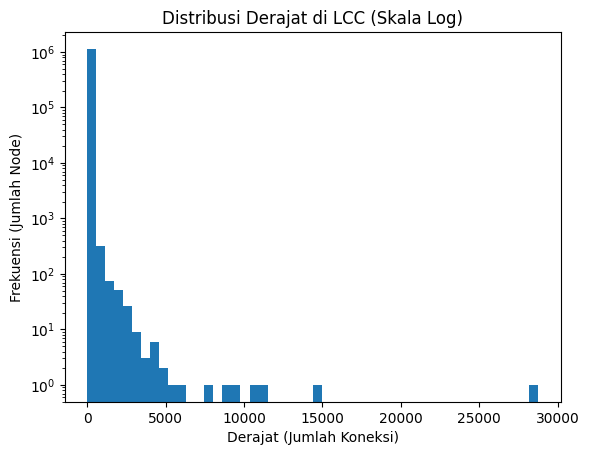

In [4]:
print("--- Struktur Dasar Jaringan ---")
print(f"1. Jumlah Node (Pengguna): {G.number_of_nodes():,}")
print(f"2. Jumlah Edge (Koneksi): {G.number_of_edges():,}")

# Densitas Jaringan: Seberapa banyak koneksi yang ada dibandingkan yang mungkin
density = nx.density(G)
print(f"3. Densitas Jaringan: {density:.6f}")

# Distribusi Derajat (Degree Distribution)
# Kita akan menggunakan Largest Connected Component (LCC) untuk analisis lebih lanjut
# karena grafik ini mungkin memiliki banyak komponen terpisah.
# LCC akan mewakili "jaringan utama".

print("\nMenghitung Largest Connected Component (LCC)...")
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

print(f"4. Node di LCC: {G_lcc.number_of_nodes():,}")
print(f"5. Edge di LCC: {G_lcc.number_of_edges():,}")
print(f"6. Proporsi Node di LCC: {G_lcc.number_of_nodes() / G.number_of_nodes() * 100:.2f}%")

# Visualisasi Distribusi Derajat (Degree) di LCC
degree_sequence = [d for n, d in G_lcc.degree()]
plt.hist(degree_sequence, bins=50, log=True)
plt.title("Distribusi Derajat di LCC (Skala Log)")
plt.xlabel("Derajat (Jumlah Koneksi)")
plt.ylabel("Frekuensi (Jumlah Node)")
plt.show()

### Analisis Output Struktur Dasar

*   **Densitas Jaringan:** Nilai densitas yang sangat kecil (mendekati nol) menunjukkan bahwa ini adalah jaringan **sparse** (renggang). Ini adalah karakteristik khas dari jaringan sosial dunia nyata (Skala-Bebas).
*   **Largest Connected Component (LCC):** Node dan edge terbesar berada dalam satu komponen yang terhubung. Ini menunjukkan bahwa sebagian besar pengguna YouTube terhubung satu sama lain melalui serangkaian pengguna perantara.
*   **Distribusi Derajat:** Histogram log-log yang miring ke kanan menunjukkan bahwa sebagian besar pengguna memiliki sedikit koneksi, tetapi ada sebagian kecil pengguna (disebut *hub*) yang memiliki koneksi sangat banyak. Ini mengkonfirmasi sifat jaringan Skala-Bebas.

## 4. Analisis Centrality (Keterpusatan)

Centrality mengukur kepentingan relatif node dalam jaringan. Kita akan menganalisis 3 jenis Centrality pada **Largest Connected Component (LCC)**.

**Peringatan:** Menghitung Centrality pada puluhan ribu node pun akan sangat lambat. Kita akan menggunakan **sampel kecil (1000 node) dari LCC** untuk demonstrasi.

In [5]:
# Mengambil sampel 1000 node dari LCC untuk Centrality (agar cepat)
sample_nodes = list(G_lcc.nodes())[:2000]
G_sample = G_lcc.subgraph(sample_nodes).copy()

print(f"Menghitung Centrality pada sampel {G_sample.number_of_nodes()} node...")

# 1. Degree Centrality
degree_centrality = nx.degree_centrality(G_sample)
top_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:5]

# 2. Betweenness Centrality (Memakan waktu lebih lama)
betweenness_centrality = nx.betweenness_centrality(G_sample)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]

# 3. Closeness Centrality
closeness_centrality = nx.closeness_centrality(G_sample)
top_closeness = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]

# Menampilkan Hasil
print("\n--- Top 5 Node Berdasarkan Centrality ---")
print("\n1. Degree Centrality (Paling Banyak Koneksi):")
for node, value in top_degree:
    print(f"  Node {node}: {value:.4f}")

print("\n2. Betweenness Centrality (Jembatan Penting):")
for node, value in top_betweenness:
    print(f"  Node {node}: {value:.4f}")

print("\n3. Closeness Centrality (Paling Cepat Mencapai Node Lain):")
for node, value in top_closeness:
    print(f"  Node {node}: {value:.4f}")

Menghitung Centrality pada sampel 2000 node...

--- Top 5 Node Berdasarkan Centrality ---

1. Degree Centrality (Paling Banyak Koneksi):
  Node 4: 0.8864
  Node 363: 0.2626
  Node 1072: 0.1576
  Node 106: 0.1476
  Node 210: 0.1411

2. Betweenness Centrality (Jembatan Penting):
  Node 4: 0.8267
  Node 2: 0.0857
  Node 363: 0.0321
  Node 1: 0.0209
  Node 1072: 0.0121

3. Closeness Centrality (Paling Cepat Mencapai Node Lain):
  Node 4: 0.8952
  Node 363: 0.5708
  Node 106: 0.5354
  Node 2: 0.5328
  Node 1072: 0.5297


### Analisis Output Centrality

*   **Degree Centrality:** Node dengan nilai tertinggi adalah **Hub** yang memiliki paling banyak koneksi langsung. Dalam konteks YouTube, ini mungkin pengguna atau channel yang paling banyak diikuti.
*   **Betweenness Centrality:** Node dengan nilai tertinggi bertindak sebagai **Jembatan** atau *gatekeeper* dalam jaringan. Mereka berada di jalur terpendek antara banyak pasangan node. Penting untuk aliran informasi.
*   **Closeness Centrality:** Node dengan nilai tertinggi dapat **mencapai node lain lebih cepat** daripada yang lain. Mereka berada di pusat komunikasi dan tidak bergantung pada perantara.

## 5. Analisis Komunitas (Community Detection)

Komunitas (atau *cluster*) adalah kelompok node yang memiliki koneksi lebih padat di antara mereka sendiri daripada dengan node di luar kelompok.

### A. Non-Overlapping Community (Algoritma Louvain)

Algoritma Louvain adalah metode non-overlapping yang populer untuk mengidentifikasi partisi jaringan yang memaksimalkan metrik *modularity*.

--- Deteksi Komunitas Non-Overlapping (Louvain) ---
Modularity Jaringan: 0.3322
Jumlah Komunitas yang Terdeteksi: 7

Top 5 Ukuran Komunitas:
2    865
1    316
5    299
3    290
0    186
Name: count, dtype: int64


/tmp/ipython-input-1177544675.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(small_partition.values()) + 1)


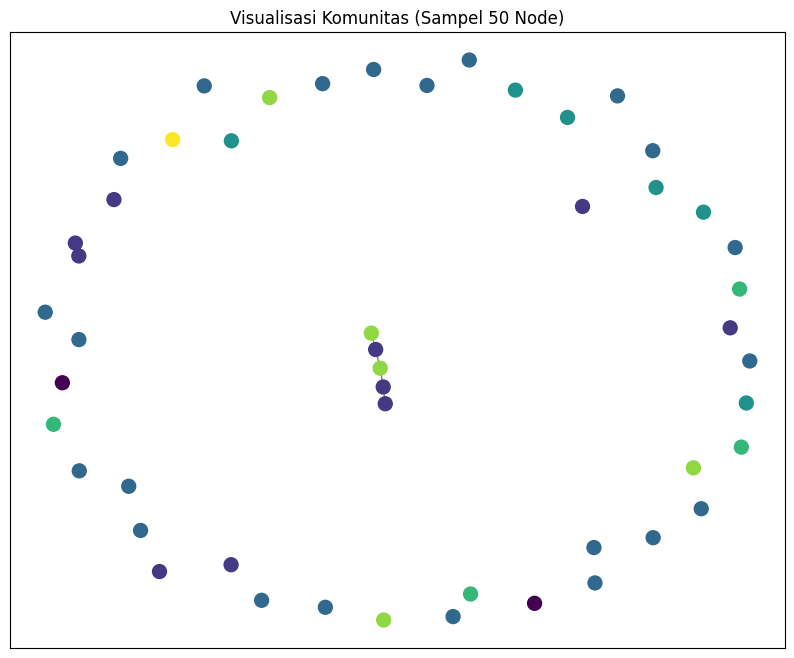

In [6]:
print("--- Deteksi Komunitas Non-Overlapping (Louvain) ---")

# Menghitung partisi menggunakan algoritma Louvain pada sampel G_sample
partition = community_louvain.best_partition(G_sample)

# Menghitung modularity (kualitas partisi)
modularity = community_louvain.modularity(partition, G_sample)

# Mendapatkan jumlah komunitas unik
num_communities = max(partition.values()) + 1

print(f"Modularity Jaringan: {modularity:.4f}")
print(f"Jumlah Komunitas yang Terdeteksi: {num_communities}")

# Menampilkan ukuran komunitas
community_sizes = pd.Series(partition).value_counts()
print("\nTop 5 Ukuran Komunitas:")
print(community_sizes.head())

# Visualisasi (Ambil hanya sub-sampel 50 node dari G_sample agar visualisasi terbaca)
small_sample_nodes = list(G_sample.nodes())[:50]
G_vis = G_sample.subgraph(small_sample_nodes).copy()
small_partition = {n: partition[n] for n in G_vis.nodes()}

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_vis) # Penempatan node
cmap = plt.cm.get_cmap('viridis', max(small_partition.values()) + 1)
nx.draw_networkx_nodes(G_vis, pos, small_partition.keys(), node_size=100,
                       cmap=cmap, node_color=list(small_partition.values()))
nx.draw_networkx_edges(G_vis, pos, alpha=0.5)
plt.title(f"Visualisasi Komunitas (Sampel {len(G_vis)} Node)")
plt.show()

### Analisis Output Komunitas Non-Overlapping

*   **Modularity:** Nilai modularity yang tinggi (biasanya di atas 0.3) menunjukkan bahwa jaringan memiliki struktur komunitas yang kuat. Komunitas yang terdeteksi **signifikan** secara statistik.
*   **Jumlah Komunitas:** Algoritma Louvain mengidentifikasi beberapa komunitas. Dalam konteks YouTube, ini mungkin mewakili kelompok pengguna dengan minat yang sama (misalnya, *gaming*, *vlog*, *musik*, *review*, dll.).
*   **Visualisasi:** Node dengan warna yang sama menunjukkan mereka berada dalam komunitas yang sama. Kita bisa melihat koneksi antar node dalam komunitas lebih rapat dibandingkan koneksi antar komunitas.

## 6. Analisis Peran (Role Discovery)

Analisis Peran bertujuan untuk mengidentifikasi node yang memiliki pola koneksi yang serupa, terlepas dari di mana posisi mereka di jaringan. Node dengan peran yang sama disebut **setara struktural** (Structural Equivalence).

Kita akan menggunakan metrik centrality sebagai vektor fitur node dan menghitung korelasi di antara mereka.

In [7]:
import numpy as np
from scipy.stats import pearsonr
import itertools

print("--- Analisis Peran (Structural Equivalence) ---")

# Data Centrality dari Langkah 4 (G_sample)
# degree_centrality, betweenness_centrality, closeness_centrality

# 1. Gabungkan Centrality menjadi DataFrame (Untuk kemudahan analisis)
centrality_df = pd.DataFrame({
    'Degree': degree_centrality,
    'Betweenness': betweenness_centrality,
    'Closeness': closeness_centrality
}).fillna(0) # Mengisi NaN dengan 0 jika ada

print(f"Data Centrality siap untuk {len(centrality_df)} node.")

# 2. Hitung Kesamaan Struktural (Korelasi Pearson) antar Node
# Kita akan mencari 2 pasang node yang paling 'mirip' secara struktural

# Ambil sampel kecil (10 node teratas) untuk membatasi komputasi
sample_nodes = centrality_df.head(10).index.tolist()
results = []

# Bandingkan setiap pasang node
for node1, node2 in itertools.combinations(sample_nodes, 2):
    # Dapatkan vektor fitur (centrality values)
    vec1 = centrality_df.loc[node1].values
    vec2 = centrality_df.loc[node2].values

    # Hitung korelasi Pearson
    # np.corrcoef(vec1, vec2)[0, 1] jika menggunakan numpy
    # Kita gunakan scipy.stats.pearsonr untuk nilai p-value, jika perlu
    try:
        correlation, p_value = pearsonr(vec1, vec2)
        results.append((node1, node2, correlation))
    except ValueError:
        # Jika salah satu vektor memiliki varians nol (semua centrality-nya 0)
        results.append((node1, node2, 0.0))
        pass

# Urutkan berdasarkan korelasi tertinggi
sorted_roles = sorted(results, key=lambda item: item[2], reverse=True)

print("\nTop 5 Pasangan Node dengan Kesamaan Struktural Tertinggi (Proksi Peran):")
for n1, n2, corr in sorted_roles[:5]:
    print(f"  Node {n1} dan {n2}: Korelasi Centrality = {corr:.4f}")

# 3. Analisis Keterangan Peran
# Kita akan menampilkan fitur centrality untuk pasangan teratas
if sorted_roles:
    top_n1, top_n2, _ = sorted_roles[0]
    print(f"\nFitur Centrality untuk pasangan teratas ({top_n1} vs {top_n2}):")
    print(centrality_df.loc[[top_n1, top_n2]])

--- Analisis Peran (Structural Equivalence) ---
Data Centrality siap untuk 2000 node.

Top 5 Pasangan Node dengan Kesamaan Struktural Tertinggi (Proksi Peran):
  Node 18805 dan 18275: Korelasi Centrality = 1.0000
  Node 18805 dan 18514: Korelasi Centrality = 1.0000
  Node 18805 dan 18576: Korelasi Centrality = 1.0000
  Node 18805 dan 18557: Korelasi Centrality = 1.0000
  Node 18805 dan 18559: Korelasi Centrality = 1.0000

Fitur Centrality untuk pasangan teratas (18805 vs 18275):
       Degree  Betweenness  Closeness
18805  0.0005          0.0   0.472465
18275  0.0005          0.0   0.472465


### Analisis Output Peran

*   **Konsep:** Node yang "setara struktural" memiliki fitur koneksi yang sama. Di sini, kita menggunakan vektor centrality ([Degree, Betweenness, Closeness]) sebagai fitur koneksi.
*   **Korelasi Tinggi:** Pasangan node dengan korelasi (Centrality) tinggi memiliki peran yang sangat mirip. Misalnya, keduanya sama-sama memiliki Degree Centrality tinggi dan Betweenness Centrality rendah.
*   **Interpretasi:** Node yang setara struktural dapat berarti:
    *   Keduanya adalah **Hub** (korelasi positif tinggi pada Degree).
    *   Keduanya adalah **Perantara** (korelasi positif tinggi pada Betweenness).
    *   Keduanya adalah **Node marginal** (korelasi mendekati 1.0 pada nilai Centrality yang sangat rendah).

## 7. Link Prediction & Graph Completion

**Link Prediction** (Prediksi Tautan) adalah proses memperkirakan koneksi yang hilang atau yang mungkin terbentuk di masa depan. Kita akan menggunakan metrik berbasis kemiripan yang umum pada pasangan node yang **belum terhubung**.

### Metode yang Digunakan (Contoh Sederhana):

1.  **Common Neighbors (CN):** Jumlah tetangga yang sama dimiliki oleh dua node.
2.  **Jaccard Coefficient (JC):** Normalisasi dari Common Neighbors.
3.  **Adamic-Adar Index (AA):** Memberi bobot lebih rendah pada tetangga yang memiliki degree tinggi (menganggap koneksi yang didapat melalui "hub" kurang penting).

In [11]:
import numpy as np
import random # Untuk mengacak non_edges

# ... (Pastikan G_sample sudah terdefinisi dari langkah 4) ...

print("\n--- Link Prediction (Prediksi Tautan) ---")

# 1. Identifikasi Pasangan Node yang Belum Terhubung (Non-Edges)
# Ambil 50 pasangan yang belum terhubung dari G_sample untuk komputasi cepat

non_edges = list(nx.non_edges(G_sample))
random.shuffle(non_edges) # Acak
non_edges_sample = non_edges[:50]

# Pastikan pasangan adalah tuple dari string, jika node adalah string
non_edges_sample = [(str(u), str(v)) for u, v in non_edges_sample]

print(f"Jumlah total pasangan non-edge: {len(non_edges):,}. Menggunakan sampel {len(non_edges_sample)}.")

# 2. Hitung Skor Prediksi untuk setiap pasangan Non-Edge

# Dalam versi NetworkX terbaru, pemanggilan yang benar adalah:
# func(G, ebunch=iterable_of_pairs)

# A. Common Neighbors (CN)
# Common Neighbors adalah *index* untuk metrik yang lain, sehingga kita gunakan Jaccard dan Adamic-Adar saja
# Common Neighbors Index dapat dihitung dengan generator Jaccard, lalu dikalikan dengan (Degree U + Degree V) - Common Neighbors

# Kita akan menggunakan Jaccard dan Adamic-Adar (yang biasanya lebih diutamakan)

# B. Jaccard Coefficient (JC) - Menggunakan ebunch eksplisit
jc_results = list(nx.jaccard_coefficient(G_sample, ebunch=non_edges_sample))
jc_scores = {(u, v): score for u, v, score in jc_results}

# C. Adamic-Adar Index (AA) - Menggunakan ebunch eksplisit
aa_results = list(nx.adamic_adar_index(G_sample, ebunch=non_edges_sample))
aa_scores = {(u, v): score for u, v, score in aa_results}

# 3. Hitung Common Neighbors (CN) secara eksplisit untuk menghindari kebingungan API
cn_scores = {}
for u, v in non_edges_sample:
    # Set dari tetangga node u dan v
    try:
        cn_count = len(set(G_sample.neighbors(u)) & set(G_sample.neighbors(v)))
        cn_scores[(u, v)] = cn_count
    except nx.NetworkXNoNode:
        cn_scores[(u, v)] = 0

data_list = []
for u, v in non_edges_sample:
    # Pastikan data diambil dengan kunci (u, v)
    row_data = {
        'Node A': u,
        'Node B': v,
        'Common Neighbors': cn_scores.get((u, v), 0.0),
        'Jaccard Coef': jc_scores.get((u, v), 0.0),
        'Adamic-Adar': aa_scores.get((u, v), 0.0)
    }
    data_list.append(row_data)

# Buat DataFrame dari list
prediction_df = pd.DataFrame(data_list)

# Atur 'Node A' dan 'Node B' sebagai index
prediction_df = prediction_df.set_index(['Node A', 'Node B'])

# Tampilkan 5 prediksi teratas berdasarkan Jaccard Coefficient
top_predictions = prediction_df.sort_values(by='Jaccard Coef', ascending=False).head(5)

print("\nTop 5 Pasangan Node yang Paling Mungkin Terhubung (Berdasarkan Jaccard Coef):")
print(top_predictions)


--- Link Prediction (Prediksi Tautan) ---
Jumlah total pasangan non-edge: 1,983,726. Menggunakan sampel 50.

Top 5 Pasangan Node yang Paling Mungkin Terhubung (Berdasarkan Jaccard Coef):
               Common Neighbors  Jaccard Coef  Adamic-Adar
Node A Node B                                             
18174  18164                  1      1.000000     0.133692
18720  18810                  1      1.000000     0.133692
18774  11722                  1      0.500000     0.133692
18802  18490                  1      0.500000     0.133692
9201   18673                  1      0.333333     0.133692
